In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import zipfile
import pathlib
import gc
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
with zipfile.ZipFile("/content/DatasetF.zip", "r") as zip_ref:
    zip_ref.extractall("/content/Dataset")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
base_path = "/content/Dataset/DatasetF"
train_data = datasets.ImageFolder(f"{base_path}/train", transform=transform)
test_data = datasets.ImageFolder(f"{base_path}/test", transform=transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
class_names = train_data.classes

In [7]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            correct += torch.sum(preds == labels).item()
    return correct / len(data_loader.dataset)

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        epoch_train_acc = correct / len(train_loader.dataset)
        epoch_train_loss = running_loss / len(train_loader)
        train_acc.append(epoch_train_acc)
        train_loss.append(epoch_train_loss)

        # Validation
        model.eval()
        val_running_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        epoch_val_acc = val_correct / len(val_loader.dataset)
        epoch_val_loss = val_running_loss / len(val_loader)
        val_acc.append(epoch_val_acc)
        val_loss.append(epoch_val_loss)

        print(f"Epoch {epoch+1:02d} | Train Acc: {epoch_train_acc:.4f}, Loss: {epoch_train_loss:.4f} | "
              f"Val Acc: {epoch_val_acc:.4f}, Loss: {epoch_val_loss:.4f}")

    return train_acc, val_acc, train_loss, val_loss



In [13]:
combinations = [
    {"lr": 0.001, "optimizer": "Adam", "epochs": 15, "batch_size": 16},
    {"lr": 0.0001, "optimizer": "SGD", "epochs": 15, "batch_size": 16},
    {"lr": 0.0001, "optimizer": "Adam", "epochs": 20, "batch_size": 32},
    {"lr": 0.001, "optimizer": "SGD", "epochs": 20, "batch_size": 32}
]

In [14]:

arch_configs = {
    "AlexNet": lambda: models.alexnet(weights=models.AlexNet_Weights.DEFAULT),
    "VGG16": lambda: models.vgg16(weights=models.VGG16_Weights.DEFAULT),
    "ResNet18": lambda: models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
    "DenseNet121": lambda: models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
}

In [15]:
import time


final_results = {}

for arch_name, arch_func in arch_configs.items():
    print(f"\n--- Training {arch_name} ---")
    final_results[arch_name] = {}

    for idx, combo in enumerate(combinations, 1):
        print(f"\nCombination {idx}: {combo}")


        start_time = time.time()


        model = arch_func()
        if arch_name == "ResNet18":
            model.fc = nn.Linear(model.fc.in_features, len(class_names))
        elif arch_name == "DenseNet121":
            model.classifier = nn.Linear(model.classifier.in_features, len(class_names))
        else:
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(class_names))
        model = model.to(device)


        if combo["optimizer"] == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=combo["lr"])
        else:
            optimizer = optim.SGD(model.parameters(), lr=combo["lr"], momentum=0.9)


        train_loader = DataLoader(train_dataset, batch_size=combo["batch_size"], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=combo["batch_size"], shuffle=False)


        train_acc, val_acc, train_loss, val_loss = train_model(
            model, nn.CrossEntropyLoss(), optimizer,
            train_loader, val_loader,
            num_epochs=combo["epochs"]
        )


        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())


        test_accuracy = sum([pred == label for pred, label in zip(all_preds, all_labels)]) / len(all_labels) * 100
        precision = precision_score(all_labels, all_preds, average='macro') * 100
        recall = recall_score(all_labels, all_preds, average='macro') * 100
        f1 = f1_score(all_labels, all_preds, average='macro') * 100


        print(f"Test Accuracy: {test_accuracy:.2f}%")
        print(f"Precision: {precision:.2f}%")
        print(f"Recall: {recall:.2f}%")
        print(f"F1 Score: {f1:.2f}%")


        end_time = time.time()
        duration = end_time - start_time
        print(f"Training time for this combination: {duration:.2f} seconds")


        final_results[arch_name][f"Combo_{idx}"] = {
            "train_acc": train_acc,
            "val_acc": val_acc,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "config": combo,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "test_accuracy": test_accuracy,
            "time_sec": round(duration, 2),
            "model": model
        }


        del model
        torch.cuda.empty_cache()
        gc.collect()



--- Training AlexNet ---

Combination 1: {'lr': 0.001, 'optimizer': 'Adam', 'epochs': 15, 'batch_size': 16}
Epoch 01 | Train Acc: 0.5287, Loss: 1.1554 | Val Acc: 0.4019, Loss: 1.3090
Epoch 02 | Train Acc: 0.6102, Loss: 0.8996 | Val Acc: 0.4952, Loss: 0.9667
Epoch 03 | Train Acc: 0.5210, Loss: 0.9615 | Val Acc: 0.6627, Loss: 0.8760
Epoch 04 | Train Acc: 0.4347, Loss: 1.1029 | Val Acc: 0.4426, Loss: 1.0530
Epoch 05 | Train Acc: 0.5737, Loss: 0.9632 | Val Acc: 0.5478, Loss: 1.0210
Epoch 06 | Train Acc: 0.3922, Loss: 1.1186 | Val Acc: 0.3325, Loss: 1.1015
Epoch 07 | Train Acc: 0.3275, Loss: 1.1002 | Val Acc: 0.3254, Loss: 1.0988
Epoch 08 | Train Acc: 0.3216, Loss: 1.0996 | Val Acc: 0.3254, Loss: 1.0998
Epoch 09 | Train Acc: 0.3323, Loss: 1.1000 | Val Acc: 0.3254, Loss: 1.0997
Epoch 10 | Train Acc: 0.3126, Loss: 1.0996 | Val Acc: 0.3325, Loss: 1.0990
Epoch 11 | Train Acc: 0.3347, Loss: 1.0992 | Val Acc: 0.3325, Loss: 1.0989
Epoch 12 | Train Acc: 0.3527, Loss: 1.0988 | Val Acc: 0.3254, Loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 32.16%
Precision: 10.72%
Recall: 33.33%
F1 Score: 16.22%
Training time for this combination: 441.80 seconds

Combination 2: {'lr': 0.0001, 'optimizer': 'SGD', 'epochs': 15, 'batch_size': 16}
Epoch 01 | Train Acc: 0.9299, Loss: 0.1874 | Val Acc: 0.9952, Loss: 0.0353
Epoch 02 | Train Acc: 0.9922, Loss: 0.0353 | Val Acc: 0.9928, Loss: 0.0244
Epoch 03 | Train Acc: 0.9940, Loss: 0.0205 | Val Acc: 0.9952, Loss: 0.0199
Epoch 04 | Train Acc: 0.9970, Loss: 0.0161 | Val Acc: 0.9952, Loss: 0.0180
Epoch 05 | Train Acc: 0.9970, Loss: 0.0128 | Val Acc: 0.9952, Loss: 0.0171
Epoch 06 | Train Acc: 0.9982, Loss: 0.0108 | Val Acc: 0.9952, Loss: 0.0160
Epoch 07 | Train Acc: 0.9988, Loss: 0.0070 | Val Acc: 0.9952, Loss: 0.0156
Epoch 08 | Train Acc: 0.9994, Loss: 0.0068 | Val Acc: 0.9952, Loss: 0.0148
Epoch 09 | Train Acc: 0.9994, Loss: 0.0064 | Val Acc: 0.9952, Loss: 0.0146
Epoch 10 | Train Acc: 0.9994, Loss: 0.0044 | Val Acc: 0.9952, Loss: 0.0144
Epoch 11 | Train Acc: 0.9994, Loss: 0.0042 |

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.8MB/s]


Epoch 01 | Train Acc: 0.5096, Loss: 2.0534 | Val Acc: 0.6340, Loss: 0.7882
Epoch 02 | Train Acc: 0.6910, Loss: 0.8593 | Val Acc: 0.6077, Loss: 0.9912
Epoch 03 | Train Acc: 0.8000, Loss: 0.5589 | Val Acc: 0.8182, Loss: 0.4605
Epoch 04 | Train Acc: 0.8713, Loss: 0.3977 | Val Acc: 0.8349, Loss: 0.4223
Epoch 05 | Train Acc: 0.8778, Loss: 0.3324 | Val Acc: 0.8062, Loss: 0.5321
Epoch 06 | Train Acc: 0.8838, Loss: 0.3491 | Val Acc: 0.8971, Loss: 0.3814
Epoch 07 | Train Acc: 0.8814, Loss: 0.3429 | Val Acc: 0.8565, Loss: 0.4977
Epoch 08 | Train Acc: 0.8796, Loss: 0.3616 | Val Acc: 0.8708, Loss: 0.3044
Epoch 09 | Train Acc: 0.8940, Loss: 0.2960 | Val Acc: 0.8636, Loss: 0.3092
Epoch 10 | Train Acc: 0.8970, Loss: 0.2951 | Val Acc: 0.9234, Loss: 0.2417
Epoch 11 | Train Acc: 0.8635, Loss: 0.4336 | Val Acc: 0.8589, Loss: 0.3448
Epoch 12 | Train Acc: 0.5976, Loss: 2.5902 | Val Acc: 0.3158, Loss: 1.1300
Epoch 13 | Train Acc: 0.3898, Loss: 1.4494 | Val Acc: 0.5407, Loss: 0.9042
Epoch 14 | Train Acc: 0.6

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.6MB/s]


Epoch 01 | Train Acc: 0.8958, Loss: 0.2961 | Val Acc: 0.9593, Loss: 0.1530
Epoch 02 | Train Acc: 0.9575, Loss: 0.1493 | Val Acc: 0.9833, Loss: 0.0720
Epoch 03 | Train Acc: 0.9665, Loss: 0.1075 | Val Acc: 0.9785, Loss: 0.0640
Epoch 04 | Train Acc: 0.9671, Loss: 0.0955 | Val Acc: 0.9569, Loss: 0.1225
Epoch 05 | Train Acc: 0.9557, Loss: 0.1400 | Val Acc: 0.9211, Loss: 0.2491
Epoch 06 | Train Acc: 0.9683, Loss: 0.1208 | Val Acc: 0.9737, Loss: 0.0990
Epoch 07 | Train Acc: 0.9814, Loss: 0.0512 | Val Acc: 0.9187, Loss: 0.2423
Epoch 08 | Train Acc: 0.9904, Loss: 0.0424 | Val Acc: 0.9856, Loss: 0.0502
Epoch 09 | Train Acc: 0.9623, Loss: 0.1104 | Val Acc: 0.9665, Loss: 0.0795
Epoch 10 | Train Acc: 0.9832, Loss: 0.0473 | Val Acc: 0.9761, Loss: 0.0850
Epoch 11 | Train Acc: 0.9683, Loss: 0.1219 | Val Acc: 0.9785, Loss: 0.0867
Epoch 12 | Train Acc: 0.9874, Loss: 0.0482 | Val Acc: 0.9833, Loss: 0.0660
Epoch 13 | Train Acc: 0.9940, Loss: 0.0167 | Val Acc: 0.9498, Loss: 0.1812
Epoch 14 | Train Acc: 0.9

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 68.5MB/s]


Epoch 01 | Train Acc: 0.9275, Loss: 0.2170 | Val Acc: 0.9569, Loss: 0.1090
Epoch 02 | Train Acc: 0.9455, Loss: 0.1512 | Val Acc: 0.9282, Loss: 0.1699
Epoch 03 | Train Acc: 0.9437, Loss: 0.1606 | Val Acc: 0.9785, Loss: 0.0636
Epoch 04 | Train Acc: 0.9671, Loss: 0.1050 | Val Acc: 0.9761, Loss: 0.0526
Epoch 05 | Train Acc: 0.9737, Loss: 0.0883 | Val Acc: 0.9641, Loss: 0.0827
Epoch 06 | Train Acc: 0.9743, Loss: 0.0786 | Val Acc: 0.9354, Loss: 0.1692
Epoch 07 | Train Acc: 0.9593, Loss: 0.1322 | Val Acc: 0.9211, Loss: 0.2964
Epoch 08 | Train Acc: 0.9509, Loss: 0.1466 | Val Acc: 0.9569, Loss: 0.1368
Epoch 09 | Train Acc: 0.9665, Loss: 0.1059 | Val Acc: 0.9713, Loss: 0.0592
Epoch 10 | Train Acc: 0.9575, Loss: 0.1215 | Val Acc: 0.9809, Loss: 0.0516
Epoch 11 | Train Acc: 0.9772, Loss: 0.0626 | Val Acc: 0.9354, Loss: 0.1428
Epoch 12 | Train Acc: 0.9701, Loss: 0.0912 | Val Acc: 0.9833, Loss: 0.0364
Epoch 13 | Train Acc: 0.9844, Loss: 0.0449 | Val Acc: 0.9833, Loss: 0.0356
Epoch 14 | Train Acc: 0.9

In [16]:
print("\n Overall Final Test Accuracy Summary:")
print("=======================================")
for arch_name, combos in final_results.items():
    print(f"\n Architecture: {arch_name}")
    for combo_key, result in combos.items():
        final_test_acc = result['test_accuracy']
        config = result['config']
        print(f"  {combo_key} | LR: {config['lr']}, Optimizer: {config['optimizer']}, "
              f"Epochs: {config['epochs']}, Batch Size: {config['batch_size']} "
              f"=> Final Test Acc: {final_test_acc:.2f}%")



 Overall Final Test Accuracy Summary:

 Architecture: AlexNet
  Combo_1 | LR: 0.001, Optimizer: Adam, Epochs: 15, Batch Size: 16 => Final Test Acc: 32.16%
  Combo_2 | LR: 0.0001, Optimizer: SGD, Epochs: 15, Batch Size: 16 => Final Test Acc: 99.50%
  Combo_3 | LR: 0.0001, Optimizer: Adam, Epochs: 20, Batch Size: 32 => Final Test Acc: 99.50%
  Combo_4 | LR: 0.001, Optimizer: SGD, Epochs: 20, Batch Size: 32 => Final Test Acc: 99.50%

 Architecture: VGG16
  Combo_1 | LR: 0.001, Optimizer: Adam, Epochs: 15, Batch Size: 16 => Final Test Acc: 69.60%
  Combo_2 | LR: 0.0001, Optimizer: SGD, Epochs: 15, Batch Size: 16 => Final Test Acc: 99.50%
  Combo_3 | LR: 0.0001, Optimizer: Adam, Epochs: 20, Batch Size: 32 => Final Test Acc: 99.50%
  Combo_4 | LR: 0.001, Optimizer: SGD, Epochs: 20, Batch Size: 32 => Final Test Acc: 99.50%

 Architecture: ResNet18
  Combo_1 | LR: 0.001, Optimizer: Adam, Epochs: 15, Batch Size: 16 => Final Test Acc: 97.99%
  Combo_2 | LR: 0.0001, Optimizer: SGD, Epochs: 15, B

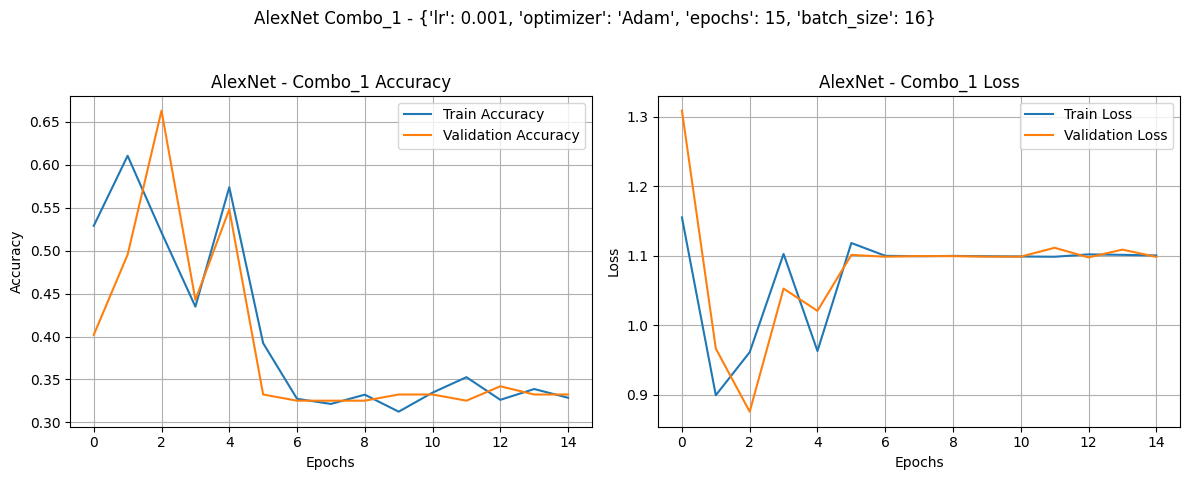

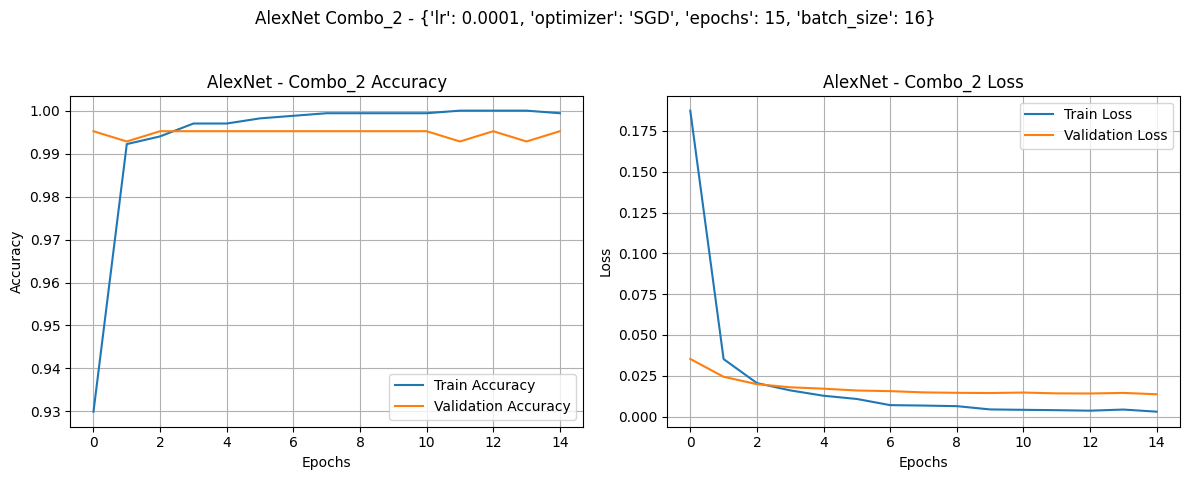

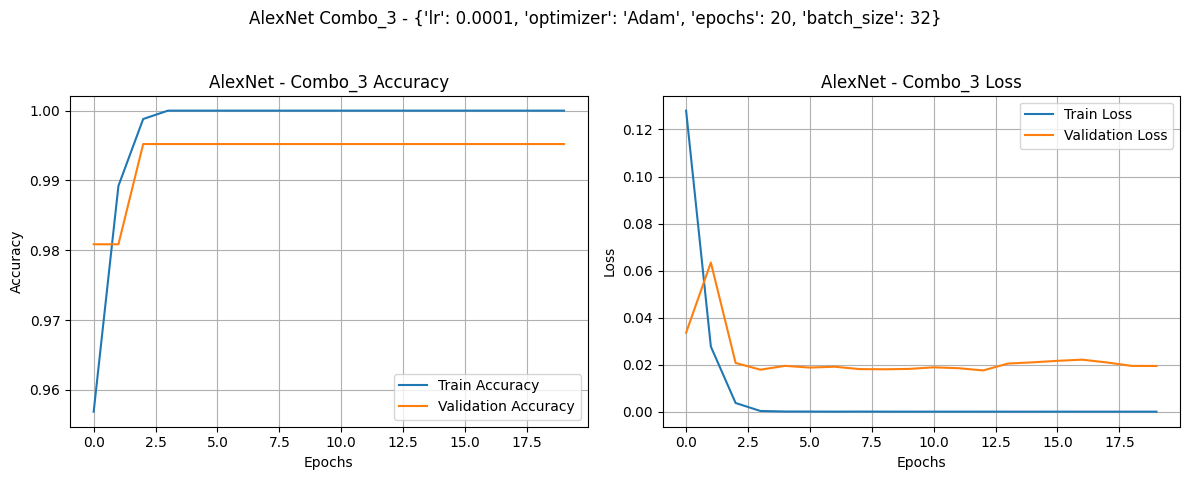

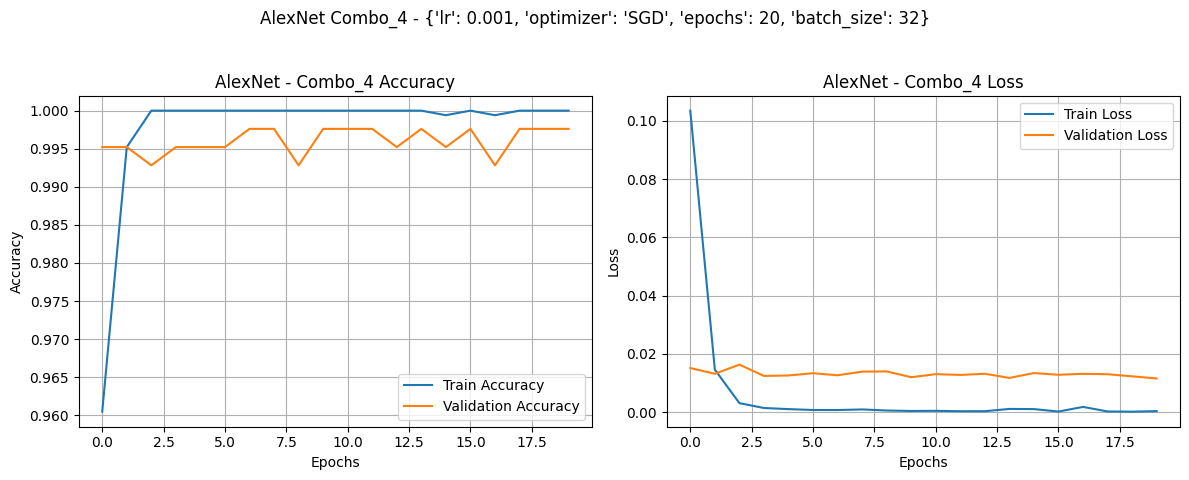

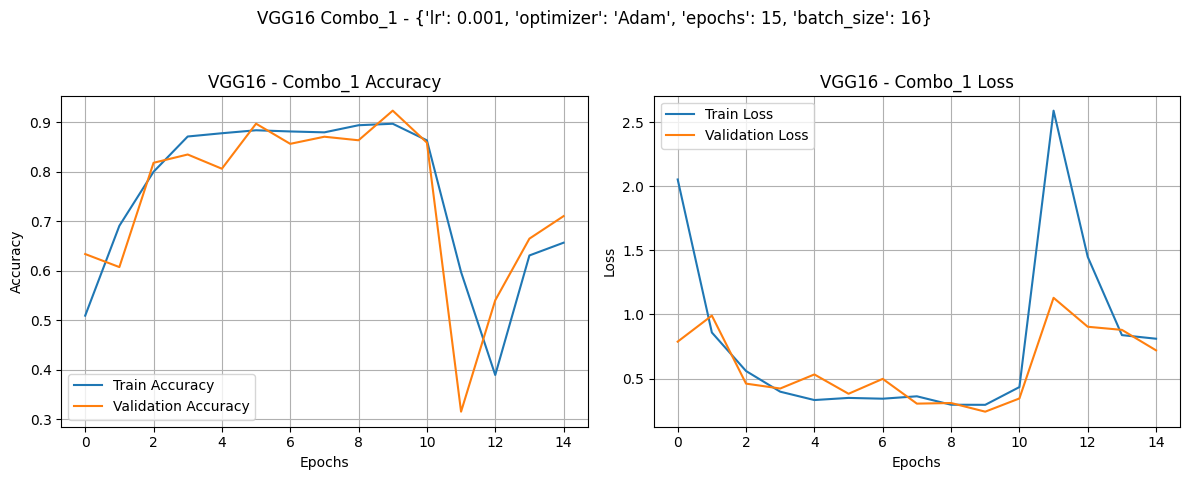

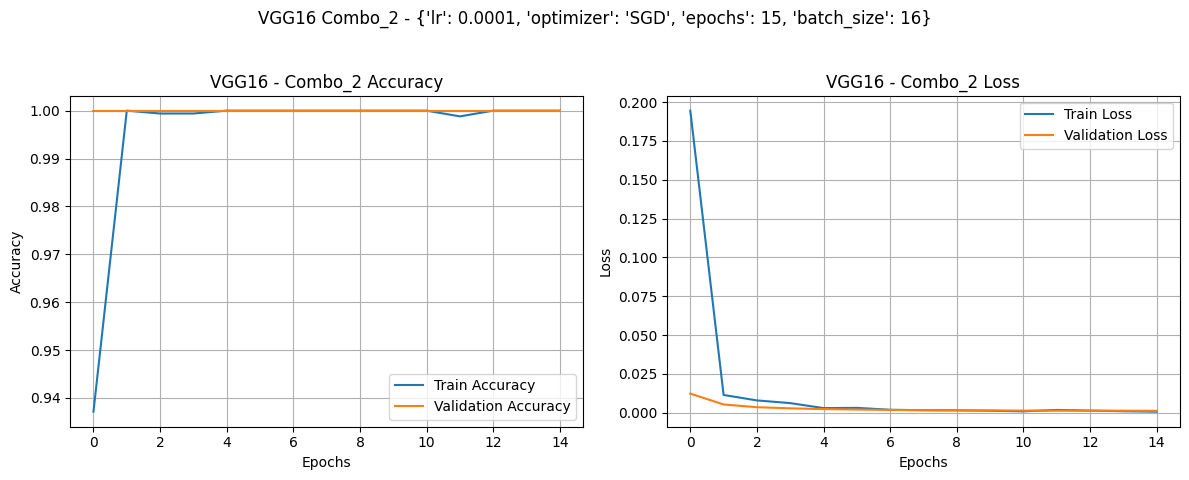

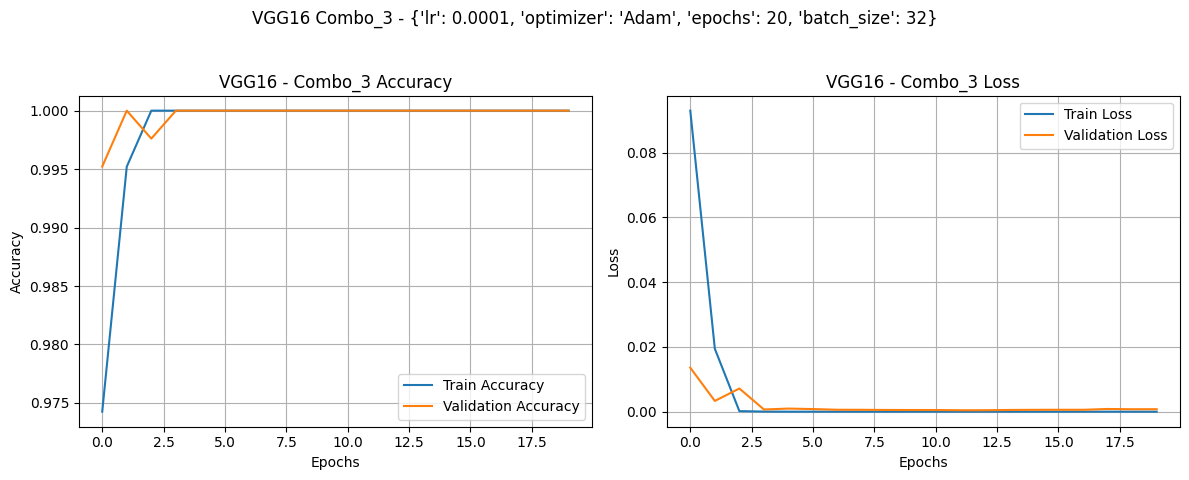

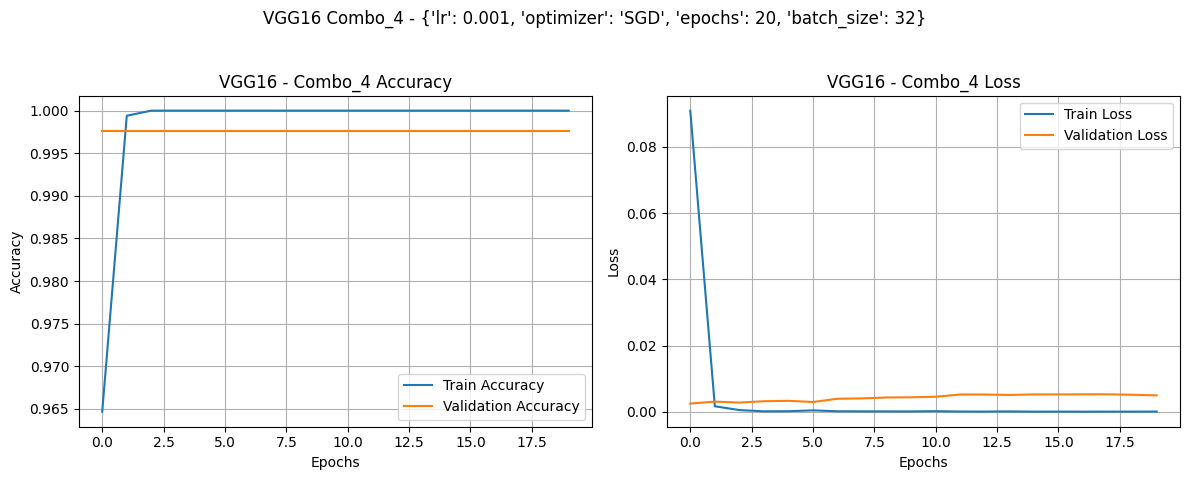

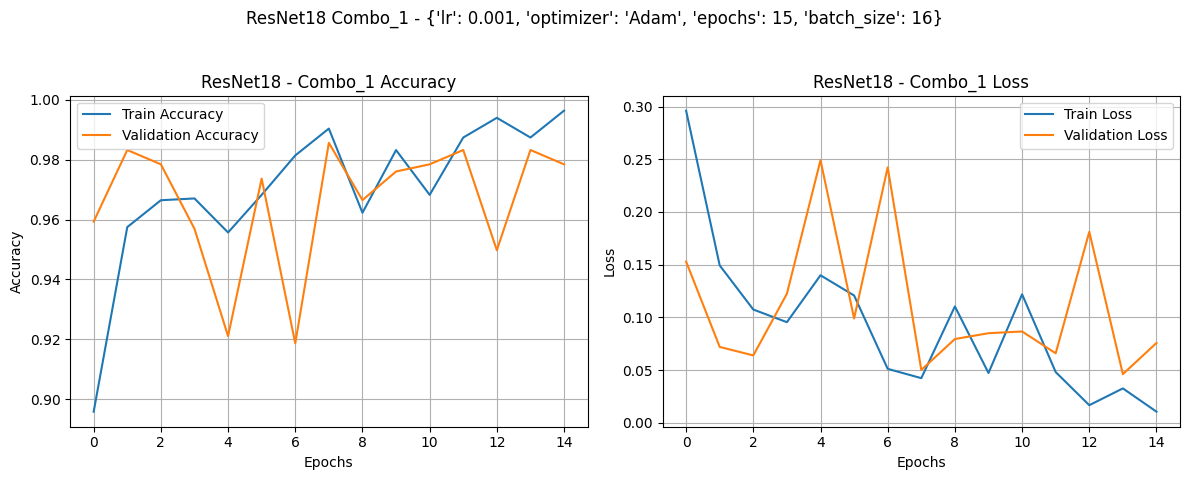

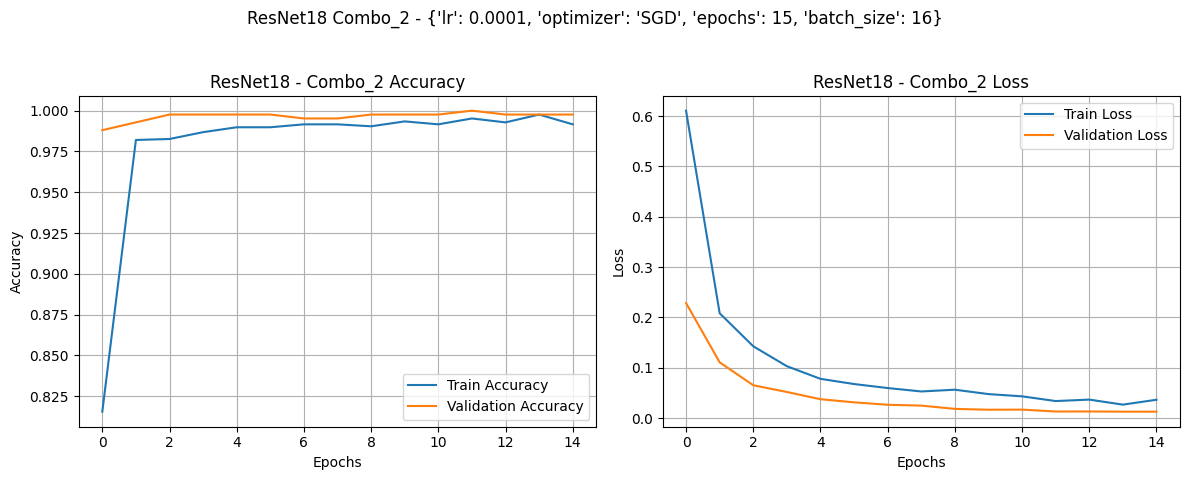

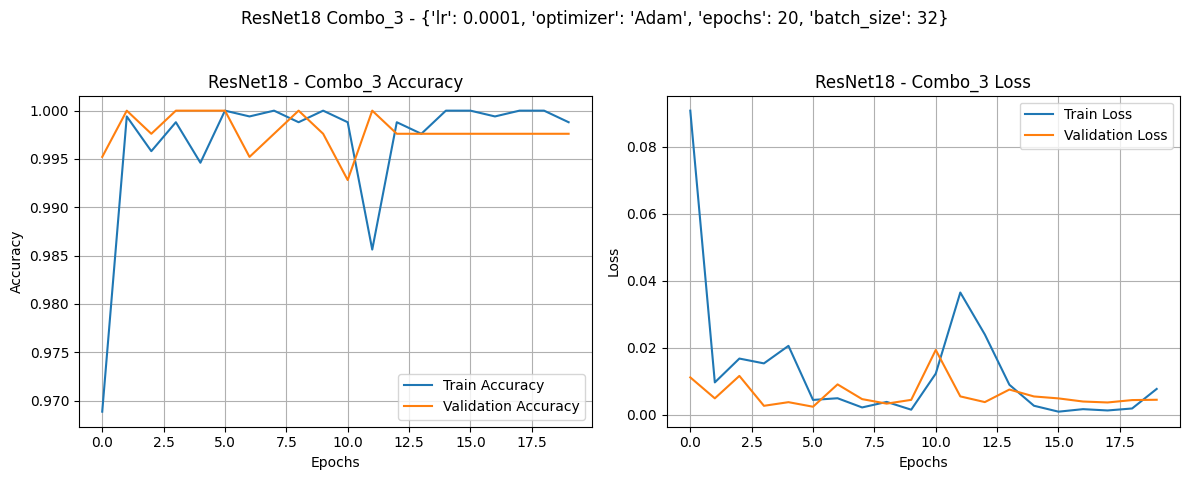

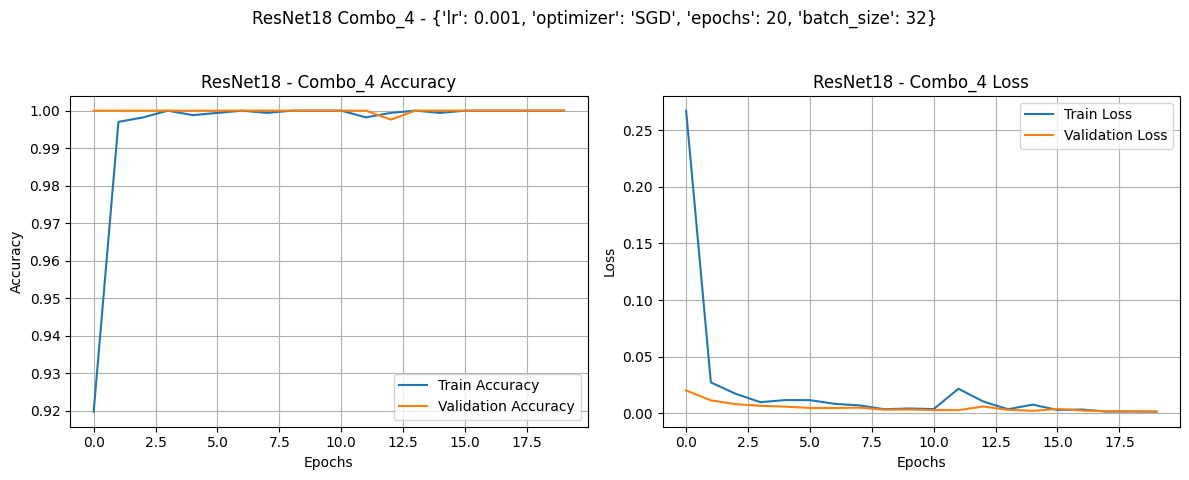

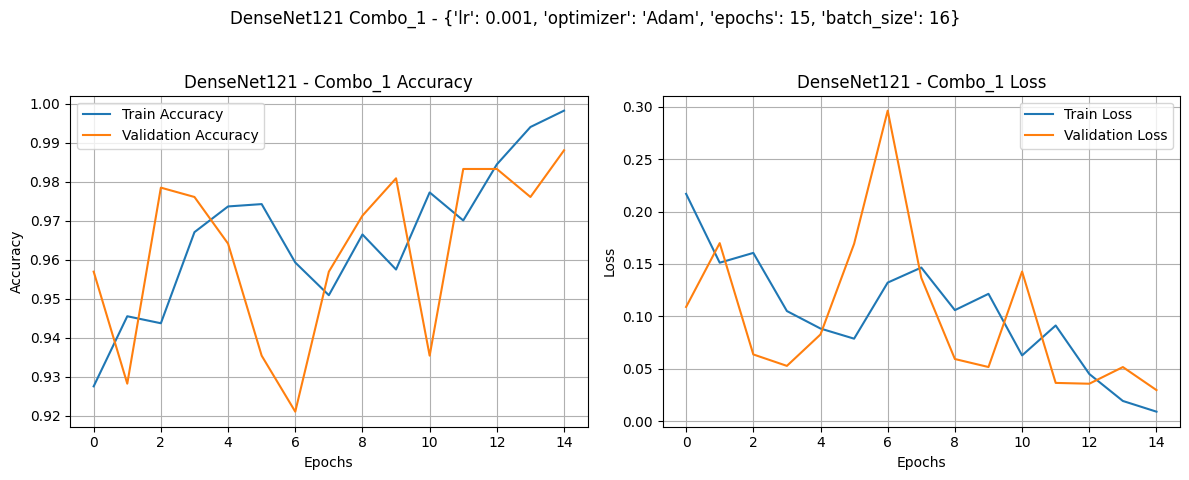

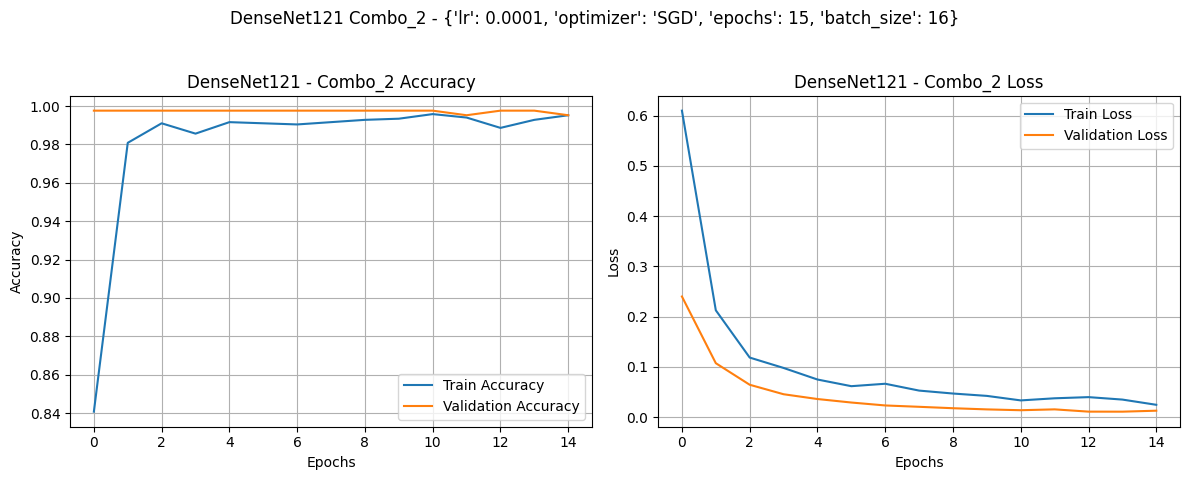

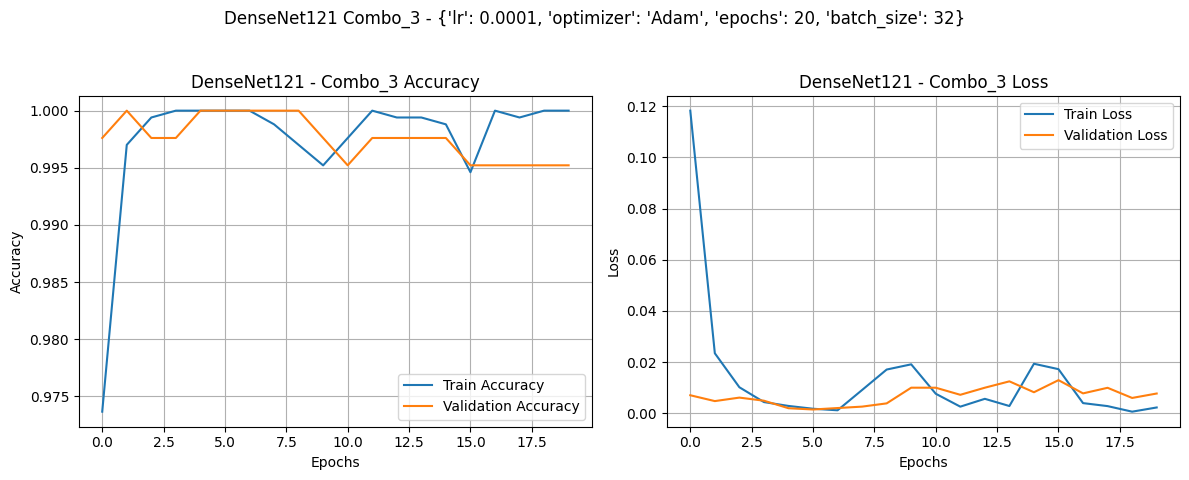

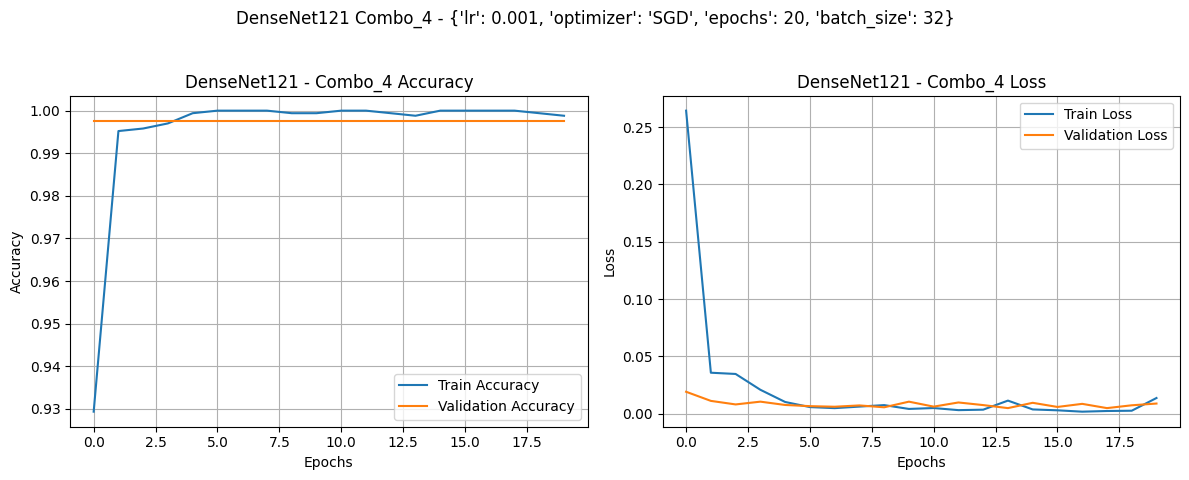

In [17]:
for arch_name in final_results:
    for combo_key, result in final_results[arch_name].items():
        plt.figure(figsize=(12, 5))


        plt.subplot(1, 2, 1)
        plt.plot(result["train_acc"], label="Train Accuracy")
        plt.plot(result["val_acc"], label="Validation Accuracy")
        plt.title(f"{arch_name} - {combo_key} Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)


        plt.subplot(1, 2, 2)
        plt.plot(result["train_loss"], label="Train Loss")
        plt.plot(result["val_loss"], label="Validation Loss")
        plt.title(f"{arch_name} - {combo_key} Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)


        plt.suptitle(f"{arch_name} {combo_key} - {result['config']}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # to make room for the suptitle
        plt.show()


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_predictions(model, dataloader, class_names, device, max_images=20):
    model.eval()
    shown_per_class = {cls: 0 for cls in range(len(class_names))}
    max_per_class = max_images // len(class_names)

    collected_images = []
    collected_labels = []
    collected_preds = []

    print("Collecting predictions...")

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)

            for i in range(inputs.size(0)):
                label = labels[i].item()
                if shown_per_class[label] < max_per_class:
                    collected_images.append(inputs[i].cpu())
                    collected_labels.append(label)
                    collected_preds.append(preds[i].item())
                    shown_per_class[label] += 1

                if sum(shown_per_class.values()) >= max_images:
                    break
            if sum(shown_per_class.values()) >= max_images:
                break

    print(" Image counts collected per class:", {class_names[k]: v for k, v in shown_per_class.items()})


    if len(collected_images) == 0:
        print("No images collected. Check if dataloader is empty or classes are missing.")
        return


    plt.figure(figsize=(15, 8))
    for idx in range(len(collected_images)):
        image = collected_images[idx].numpy().transpose((1, 2, 0))
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image = np.clip(image, 0, 1)

        plt.subplot(4, 5, idx + 1)
        plt.imshow(image)
        actual = class_names[collected_labels[idx]]
        predicted = class_names[collected_preds[idx]]
        plt.title(f"Actual: {actual}\nPred: {predicted}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


 Image counts collected per class: {'airplanes': 6, 'cars': 6, 'ship': 6}


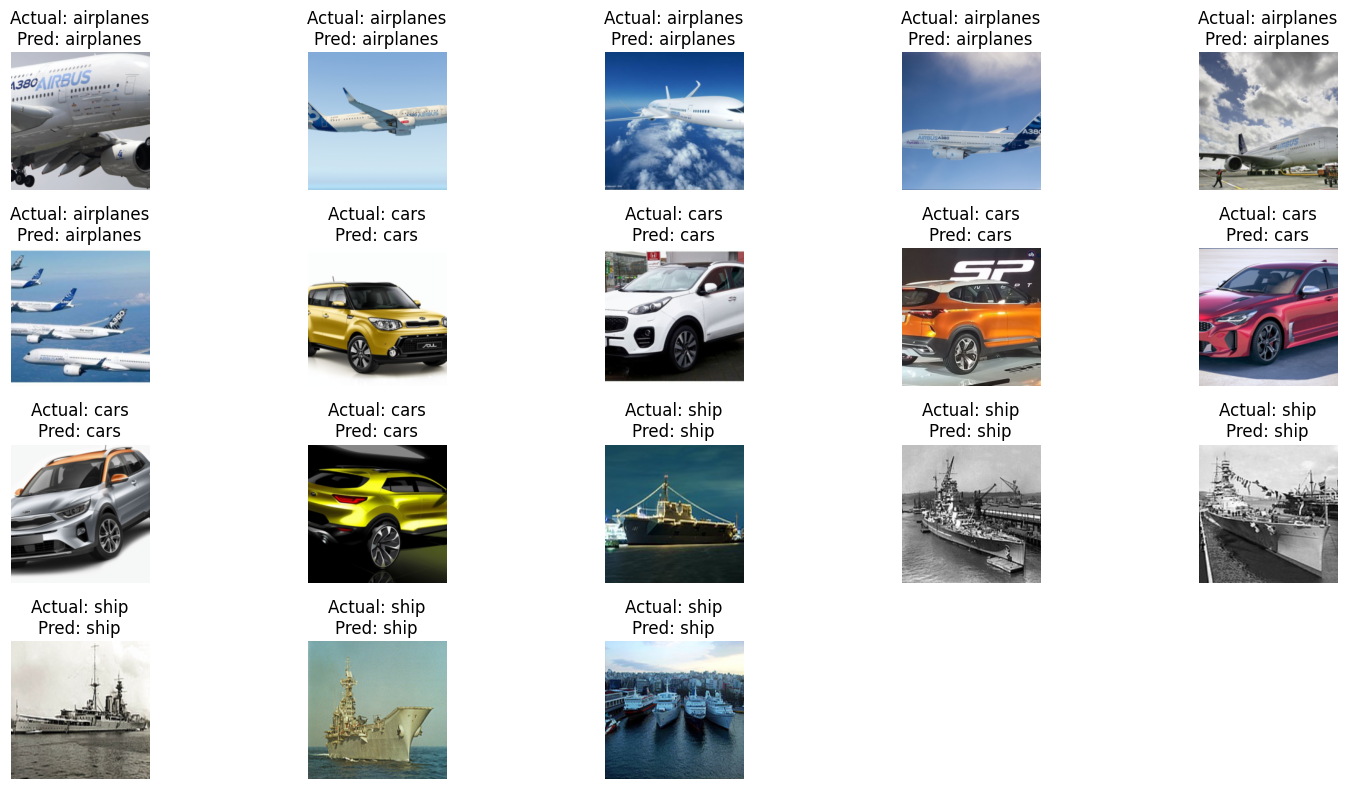

In [19]:
selected_arch = "AlexNet"
selected_combo = "Combo_2"
model_to_show = final_results[selected_arch][selected_combo]["model"]

plot_predictions(model_to_show, test_loader, class_names, device)

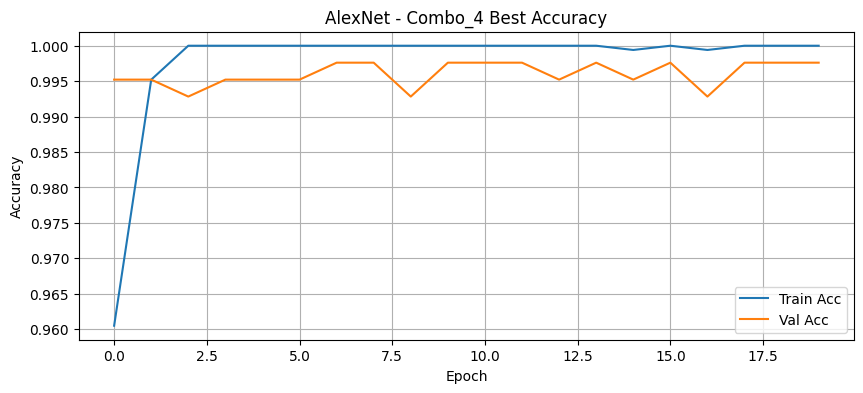

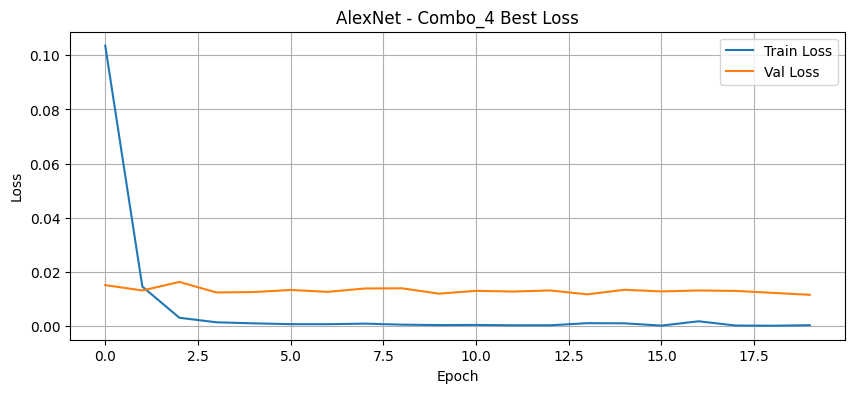

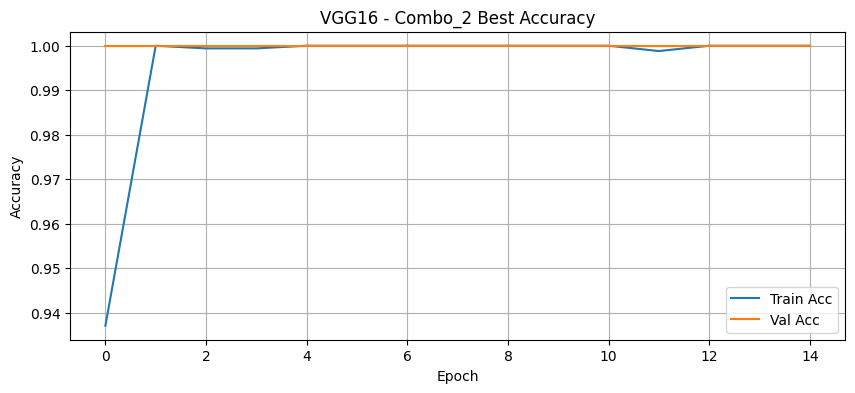

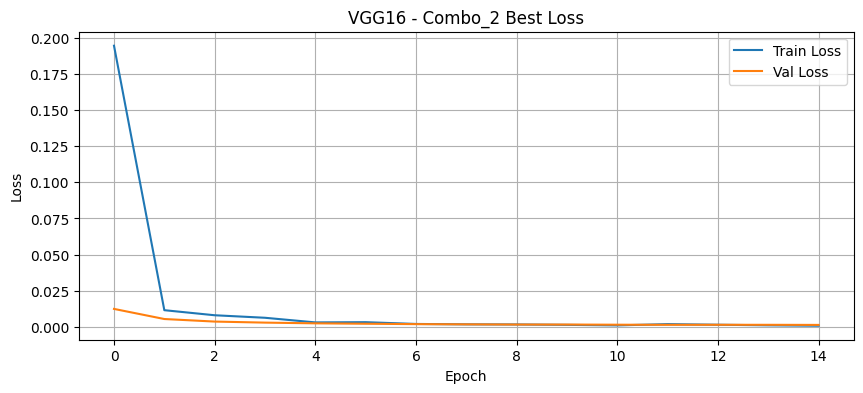

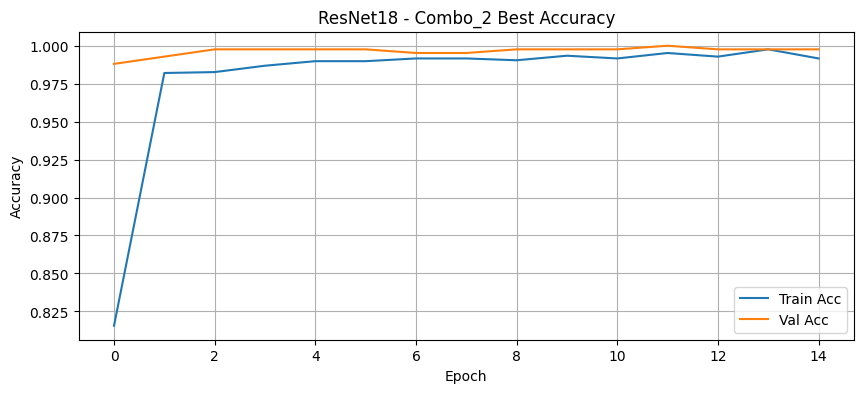

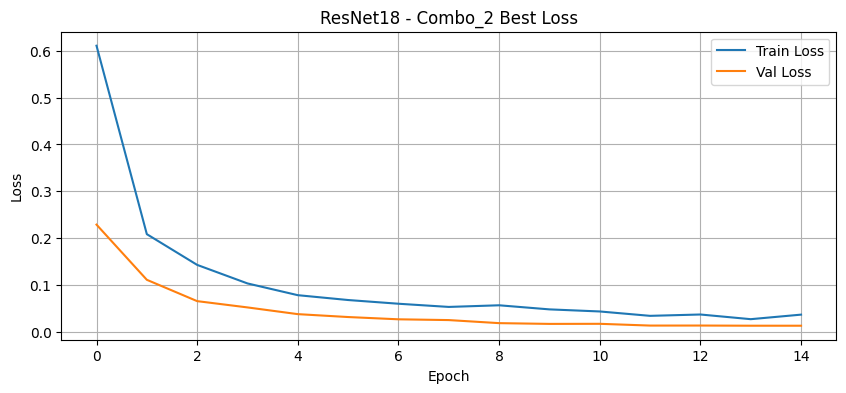

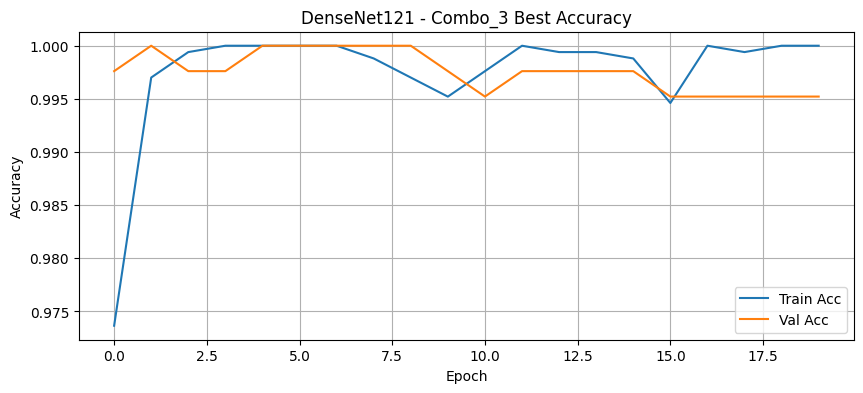

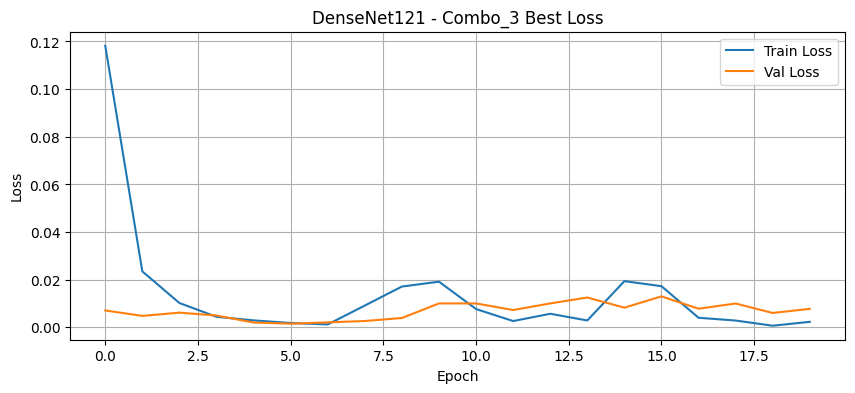

In [20]:
for arch_name in final_results:
    best_combo = None
    best_val_acc = 0
    for combo_key, result in final_results[arch_name].items():
        if max(result["val_acc"]) > best_val_acc:
            best_val_acc = max(result["val_acc"])
            best_combo = combo_key

    if best_combo:
        result = final_results[arch_name][best_combo]


        plt.figure(figsize=(10, 4))
        plt.plot(result["train_acc"], label="Train Acc")
        plt.plot(result["val_acc"], label="Val Acc")
        plt.title(f"{arch_name} - {best_combo} Best Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()


        plt.figure(figsize=(10, 4))
        plt.plot(result["train_loss"], label="Train Loss")
        plt.plot(result["val_loss"], label="Val Loss")
        plt.title(f"{arch_name} - {best_combo} Best Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
